 **Goal:** To explore and visualize different sampling techniques for language models.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
torch.manual_seed(0)

Toy logits

In [2]:
vocab = ["the", "cat", "sat", "on", "mat", ".", "<eos>"]
logits = torch.tensor([5.0, 4.0, 3.5, 3.0, 2.5, 2.0, 1.0])

Softmax with temperature

In [3]:
def softmax_with_temp(logits, temp):
    return torch.softmax(logits / temp, dim=-1)

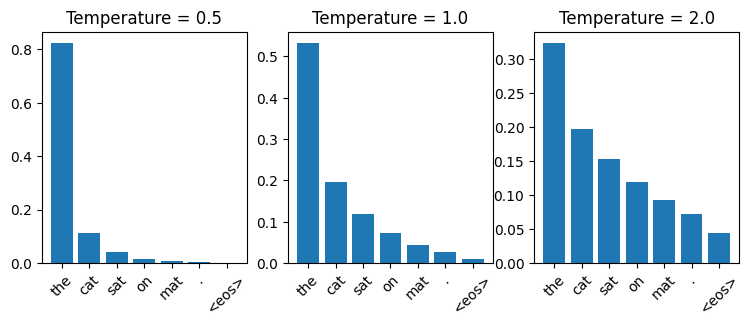

In [4]:
temps = [0.5, 1.0, 2.0]

plt.figure(figsize=(9,3))
for i, t in enumerate(temps):
    probs = softmax_with_temp(logits, t)
    plt.subplot(1,3,i+1)
    plt.bar(vocab, probs)
    plt.title(f"Temperature = {t}")
    plt.xticks(rotation=45)

plt.show()

Implement top-k sampling

In [5]:
def top_k_sample(logits, k):
    values, indices = torch.topk(logits, k)
    probs = torch.softmax(values, dim=-1)
    idx = torch.multinomial(probs, 1)
    return indices[idx].item()

Implement top-p (nucleus) sampling

In [6]:
def top_p_sample(logits, p):
    sorted_logits, sorted_idx = torch.sort(logits, descending=True)
    probs = torch.softmax(sorted_logits, dim=-1)
    cumprobs = torch.cumsum(probs, dim=-1)

    cutoff = cumprobs <= p
    cutoff[0] = True

    filtered_logits = sorted_logits[cutoff]
    filtered_idx = sorted_idx[cutoff]

    probs = torch.softmax(filtered_logits, dim=-1)
    idx = torch.multinomial(probs, 1)
    return filtered_idx[idx].item()

Unified sampler (temp + top-k + top-p)

In [7]:
def sample(logits, temp=1.0, top_k=None, top_p=None):
    logits = logits / temp

    if top_k is not None:
        values, idx = torch.topk(logits, top_k)
        probs = torch.softmax(values, dim=-1)
        return idx[torch.multinomial(probs, 1)].item()

    if top_p is not None:
        return top_p_sample(logits, top_p)

    probs = torch.softmax(logits, dim=-1)
    return torch.multinomial(probs, 1).item()

Sampler dashboard (interactive sweep)

In [8]:
def generate(n=50, **kwargs):
    return [vocab[sample(logits, **kwargs)] for _ in range(n)]

In [9]:
print("temp=0.7:", generate(temp=0.7))
print("temp=1.0:", generate(temp=1.0))
print("top_k=3:", generate(top_k=3))
print("top_p=0.8:", generate(top_p=0.8))

temp=0.7: ['the', 'the', 'the', 'cat', 'cat', 'the', 'the', 'the', 'sat', 'sat', 'mat', 'the', 'the', 'sat', 'the', 'cat', 'cat', 'the', 'sat', 'sat', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'cat', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
temp=1.0: ['the', 'cat', 'sat', 'the', 'the', 'the', 'sat', 'on', 'the', 'sat', 'the', 'cat', 'sat', 'the', 'the', 'the', 'sat', 'the', '<eos>', 'the', 'the', 'sat', 'the', 'the', 'sat', 'the', 'the', 'the', 'sat', 'sat', 'the', 'sat', 'on', '.', 'the', 'mat', 'the', 'the', 'the', 'the', 'the', 'on', 'on', 'the', 'the', 'mat', 'the', 'cat', 'cat', '<eos>']
top_k=3: ['the', 'the', 'the', 'cat', 'the', 'the', 'sat', 'cat', 'the', 'cat', 'the', 'the', 'sat', 'sat', 'sat', 'cat', 'the', 'the', 'the', 'cat', 'cat', 'the', 'the', 'the', 'cat', 'the', 'the', 'the', 'cat', 'the', 'the', 'the', 'the', 'sat', 'the', 'the', 'sat', 'the', 'cat

Plot entropy vs diversity

In [10]:
def entropy(probs):
    return -torch.sum(probs * torch.log(probs + 1e-9))

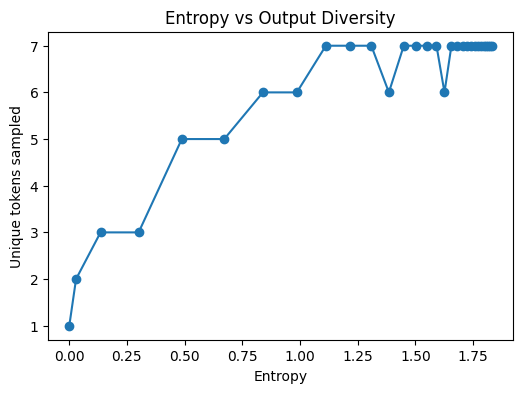

In [11]:
temps = torch.linspace(0.1, 2.5, 30)
entropies = []
diversities = []

for t in temps:
    probs = softmax_with_temp(logits, t)
    entropies.append(entropy(probs).item())
    samples = generate(n=200, temp=t.item())
    diversities.append(len(set(samples)))

plt.figure(figsize=(6,4))
plt.plot(entropies, diversities, marker='o')
plt.xlabel("Entropy")
plt.ylabel("Unique tokens sampled")
plt.title("Entropy vs Output Diversity")
plt.show()

Temperature = 0 (argmax)

In [12]:
def argmax_sample(logits):
    return torch.argmax(logits).item()

[argmax_sample(logits) for _ in range(10)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

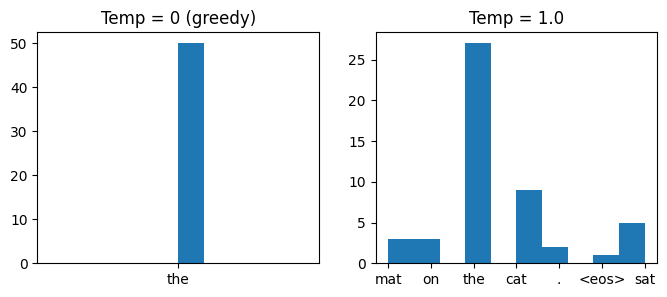

In [13]:
greedy = [vocab[argmax_sample(logits)] for _ in range(50)]
random = generate(n=50, temp=1.0)

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.hist(greedy)
plt.title("Temp = 0 (greedy)")

plt.subplot(1,2,2)
plt.hist(random)
plt.title("Temp = 1.0")

plt.show()

##Notebook Summary

**Achieved:**

*   Implemented various language model sampling techniques: softmax with temperature, top-k, and top-p (nucleus) sampling.
*   Demonstrated how these sampling methods influence token generation using toy logits and a small vocabulary.
*  Visualized the effect of temperature on probability distributions and the relationship between output entropy and diversity.
* Compared greedy sampling (Temperature = 0) with more diverse sampling techniques.


**Result:** Demonstrated how different sampling strategies influence the generated text, from deterministic greedy sampling to more varied outputs with higher temperatures and restricted sampling (top-k, top-p).